In [5]:
# libraries
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
!pip install -r requirements.txt

  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached psycopg2_binary-2.9.3-cp38-cp38-macosx_10_14_x86_64.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (2.2 MB)
  Using cached beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached pyspark-3.0.1-py2.py3-none-any.whl
  Using cached matplotlib-3.5.2-cp38-cp38-macosx_10_9_x86_64.whl (7.3 MB)
  Using cached py4j-0.10.9-py2.py3-none-any.whl (198 kB)
  Using cached nbconvert-6.5.0-py3-none-any.whl (561 kB)
  Using cached ipywidgets-7.7.1-py2.py3-none-any.whl (123 kB)
  Using cached jupyter_console-6.4.4-py3-none-any.whl (22 kB)
  Using cached notebook-6.4.12-py3-none-any.whl (9.9 MB)
  Using cached qtconsole-5.3.1-py3-none-any.whl (120 kB)
  Using cached soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached urllib3-1.26.10-py2.py3-none-any.whl (139 kB)
  Using cached cha

In [6]:
# # functions
import pyspark.sql.functions as F
# data types
from pyspark.sql.types import *
# import datetime 
from datetime import date as dt

## Upload data onto MongoDB and Data Cleaning

In [7]:
#read data in csv format
git = pd.read_csv('/Users/yilingng/Documents/DMS_fcp/gitData.csv')
issues = pd.read_csv('/Users/yilingng/Documents/DMS_fcp/gitIssues.csv')

In [8]:
# check the shape of the data
print(git.shape)
print(issues.shape)

(60996, 30)
(32329, 22)


In [9]:
#data inspection
print(git.info())
print(issues.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60996 entries, 0 to 60995
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          60996 non-null  int64  
 1   hash                60996 non-null  object 
 2   msg                 60996 non-null  object 
 3   author_name         60996 non-null  object 
 4   committer_name      60996 non-null  object 
 5   author_date         60996 non-null  object 
 6   author_timezone     60996 non-null  int64  
 7   committer_date      60996 non-null  object 
 8   committer_timezone  60996 non-null  int64  
 9   branches            60996 non-null  object 
 10  in_main_branch      60996 non-null  bool   
 11  merge               60996 non-null  bool   
 12  parents             60996 non-null  object 
 13  project_name        60996 non-null  object 
 14  deletions           60996 non-null  int64  
 15  insertions          60996 non-null  int64  
 16  line

In [157]:
# create a new column of project types for gitData, which contains only pytorch and tensorflow 
regx = r'({})'.format('|'.join(['pytorch', 'audio', 'text', 'vision', 'serve', 'torchrec','elastic', 'xla']))
git['project_type'] = git['project_name'].str.replace(regx, "pytorch").fillna(git['project_name'])

/var/folders/yr/s6gbqy0s2kd5cn1_s40p4b2w0000gn/T/ipykernel_6230/3902335322.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  git['project_type'] = git['project_name'].str.replace(regx, "pytorch").fillna(git['project_name'])


In [10]:
# let's connect to the localhost
client = MongoClient()

# let's create a database 
db = client.github

# collection for git issues
gitIssues = db.gitIssues

# print connection
print("""
Database
==========
{}

Collection
==========
{}
""".format(db, gitIssues), flush=True
)


Database
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'github')

Collection
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'github'), 'gitIssues')



In [26]:
%%time 
##
# slow loading of data
d_gitissue = {}
# pass data 
for i in issues.index:
    d_gitissue = {
        "Questions": {
            "Title": issues.loc[i,"title"],
            "Body": issues.loc[i,"body"]
        },
        "User" : {
            "Username" : issues.loc[i, "user"],
            "User_ID" :  issues.loc[i,"user_id"]
        },
        "State" : {
            "State" : issues.loc[i, "state"],
            "Created_at" :  issues.loc[i,"created_at"],
            "Updated_at" :  issues.loc[i,"updated_at"],
            "Closed_at" : issues.loc[i, "closed_at"]
        },
        "Assignees" : issues.loc[i, "assignees"],
        "Closed_by" : issues.loc[i, "closed_by"],
        "Labels" : issues.loc[i, "labels"],
        "Reactions" : issues.loc[i, "reactions"],
        "N_comments" : issues.loc[i, "n_comments"].astype(str),
        "Projects" : issues.loc[i, "project"]
    }
    if i == 0:
        gitIssues.insert_one(d_gitissue)
    else: 
        if issues.loc[i, 'title'] == issues.loc[i-1,'title']:
            continue
        else:
            gitIssues.insert_one(d_gitissue)

CPU times: user 4.93 s, sys: 132 ms, total: 5.06 s
Wall time: 11.1 s


In [11]:
# new collection for issue comment
IssueComment = db.IssueComment

# print connection
print("""
Database
==========
{}

Collection
==========
{}
""".format(db, IssueComment), flush=True
)


Database
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'github')

Collection
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'github'), 'IssueComment')



In [28]:
%%time 
##
# slow loading of data
d_comment = {}
# pass data 
for i in issues.index:
    d_comment = {
        "Title": issues.loc[i,"title"],
        "Comment_created_at": issues.loc[i,"comment_created_at"],
        "Labels" : issues.loc[i, "labels"],
        "Reactions" : issues.loc[i, "reactions"],
        "N_comments" : issues.loc[i, "n_comments"].astype(str),
        "Projects" : issues.loc[i, "project"]
    }
    IssueComment.insert_one(d_comment)

CPU times: user 5.06 s, sys: 301 ms, total: 5.37 s
Wall time: 11 s


In [12]:
# let's connect to the localhost
client = MongoClient()

# let's create a database 
db = client.github

In [161]:
# new collection for git data
gitData = db.gitData

# print connection
print("""
Database
==========
{}

Collection
==========
{}
""".format(db, gitData), flush=True
)


Database
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'github')

Collection
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'github'), 'gitData')



In [162]:
# import the git data to mongo compass
#%%time 
##
# slow loading of data
d_gitcommit = {}
#pass data
for i in git.index:
    d_gitcommit = {
        "Commit": {
            "hash":git.loc[i, "hash"],
            "Msg":{
                "msg":git.loc[i, 'msg'],
                "Author":{
                    "Author_name": git.loc[i, 'author_name'],
                    "Author_date": git.loc[i, 'author_date'],
                    "Author_timezone": git.loc[i, 'author_timezone'].astype(str)
                }
            },
            "Committer":{
                "Committer_name": git.loc[i, 'committer_name'],
                "Committer_date": git.loc[i, 'committer_date'],
                "Committer_timezone": git.loc[i, 'committer_timezone'].astype(str)
            }
        },
        "Branch":{
            "Branches": git.loc[i, 'branches'],
            "In_main_branch": git.loc[i, 'in_main_branch'].astype(str),
            "Merge": git.loc[i, 'merge'].astype(str),
            "Parents":git.loc[i, 'parents']
        },
        "Project_name": {
            "Project_type" : git.loc[i, 'project_type'],
            "Project_name": git.loc[i, 'project_name']
            },
        "File":{
            "Filename": git.loc[i, 'filename'],
            "Change_type": git.loc[i, 'change_type'],
            "Commit_change":{
                "Deletions": git.loc[i, 'deletions'].astype(str),
                "Insertions": git.loc[i, 'insertions'].astype(str),
                "Files": git.loc[i, 'files'].astype(str),
                "Lines":git.loc[i, 'lines'].astype(str)
            }
        },
        "Code_change":{
            "Path":{
                "old_path":git.loc[i, 'old_path'],
                "new_path": git.loc[i, 'new_path']
            },
            "Diff":{
                "Diff": git.loc[i, 'diff'],
                "Diff_parse":{
                    "Diff_parsed":git.loc[i, 'diff_parsed'],
                    "Deleted_lines":git.loc[i, 'deleted_lines'].astype(str)
                }
            },
            "Source_code":{
                "Source_code":git.loc[i, 'source_code'],
                "Source_code_before":git.loc[i, 'source_code_before']
            }
        },
        "Nloc":git.loc[i, 'nloc'],
        "Complexity":git.loc[i, 'complexity'],
        "Token_count":git.loc[i, 'token_count']
        
     }
    gitData.insert_one(d_gitcommit)

In [163]:
# let's connect to the localhost
client = MongoClient()
# link to the database
db = client.github

# link to the collection
gitData = db.gitData
gitIssues = db.gitIssues
IssueComment = db.IssueComment


In [33]:
# data cleaning
# clean the NA values into null
# get key names
key_list_issue = []
for i in d_gitissue.keys():
    try:
        for b in d_gitissue.get(str(i)).keys():
            key_list_issue.append(str(i) + '.' + str(b))
    except:
        key_list_issue.append(i)

In [34]:
# get key names
key_list_comment = []
for i in d_comment.keys():
    try:
        for b in d_comment.get(str(i)).keys():
            key_list_comment.append(str(i) + '.' + str(b))
    except:
        key_list_comment.append(i)

In [35]:
# get key names
key_list_commit = []
for i in d_gitcommit.keys():
    try:
        for b in d_gitcommit.get(str(i)).keys():
            key_list_commit.append(str(i) + '.' + str(b))
    except:
        key_list_commit.append(i)

In [36]:
# unset NaN fields
for i in key_list_issue:
    update = gitIssues.update_many({str(i):np.nan},{"$unset": {str(i):""}})
    print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format(i, update.matched_count, update.modified_count), flush=True)


    Key: Questions.Title
    Matched: 0
    Modified: 0
    ------------
    

    Key: Questions.Body
    Matched: 175
    Modified: 175
    ------------
    

    Key: User.Username
    Matched: 0
    Modified: 0
    ------------
    

    Key: User.User_ID
    Matched: 0
    Modified: 0
    ------------
    

    Key: State.State
    Matched: 0
    Modified: 0
    ------------
    

    Key: State.Created_at
    Matched: 0
    Modified: 0
    ------------
    

    Key: State.Updated_at
    Matched: 0
    Modified: 0
    ------------
    

    Key: State.Closed_at
    Matched: 0
    Modified: 0
    ------------
    

    Key: Assignees
    Matched: 0
    Modified: 0
    ------------
    

    Key: Closed_by
    Matched: 3311
    Modified: 3311
    ------------
    

    Key: Labels
    Matched: 0
    Modified: 0
    ------------
    

    Key: Reactions
    Matched: 0
    Modified: 0
    ------------
    

    Key: N_comments
    Matched: 0
    Modified: 0
    ------------
    

  

In [37]:
# unset NaN fields
for i in key_list_comment:
    update = IssueComment.update_many({str(i):np.nan},{"$unset": {str(i):""}})
    print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format(i, update.matched_count, update.modified_count), flush=True)


    Key: Title
    Matched: 0
    Modified: 0
    ------------
    

    Key: Comment_created_at
    Matched: 0
    Modified: 0
    ------------
    

    Key: Labels
    Matched: 0
    Modified: 0
    ------------
    

    Key: Reactions
    Matched: 0
    Modified: 0
    ------------
    

    Key: N_comments
    Matched: 0
    Modified: 0
    ------------
    

    Key: Projects
    Matched: 0
    Modified: 0
    ------------
    

    Key: _id
    Matched: 0
    Modified: 0
    ------------
    


In [38]:
# unset NaN fields
for i in key_list_commit:
    update = gitData.update_many({str(i):np.nan},{"$unset": {str(i):""}})
    print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format(i, update.matched_count, update.modified_count), flush=True)


    Key: Commit.hash
    Matched: 0
    Modified: 0
    ------------
    

    Key: Commit.Msg
    Matched: 0
    Modified: 0
    ------------
    

    Key: Commit.Committer
    Matched: 0
    Modified: 0
    ------------
    

    Key: Branch.Branches
    Matched: 0
    Modified: 0
    ------------
    

    Key: Branch.In_main_branch
    Matched: 0
    Modified: 0
    ------------
    

    Key: Branch.Merge
    Matched: 0
    Modified: 0
    ------------
    

    Key: Branch.Parents
    Matched: 0
    Modified: 0
    ------------
    

    Key: Project_name
    Matched: 0
    Modified: 0
    ------------
    

    Key: File.Filename
    Matched: 0
    Modified: 0
    ------------
    

    Key: File.Change_type
    Matched: 0
    Modified: 0
    ------------
    

    Key: File.Commit_change
    Matched: 0
    Modified: 0
    ------------
    

    Key: Code_change.Path
    Matched: 0
    Modified: 0
    ------------
    

    Key: Code_change.Diff
    Matched: 0
    Modified: 0


In [39]:
# update the date date from string to datetime
# change the data type of 'Created_at', 'Updated_at', and 'closed_at' in gitissues
update = gitIssues.update_many(
    {},
    [{"$set": {
        "State.Created_at": {
            "$toDate":"$State.Created_at" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Created_at", update.matched_count, update.modified_count), flush=True)


    Key: Created_at
    Matched: 5513
    Modified: 5513
    ------------
    


In [40]:
# change the data type of 'Created_at', 'Updated_at', and 'closed_at' in gitissues
update = gitIssues.update_many(
    {},
    [{"$set": {
        "State.Updated_at": {
            "$toDate":"$State.Updated_at" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Updated_at", update.matched_count, update.modified_count), flush=True)


    Key: Updated_at
    Matched: 5513
    Modified: 5513
    ------------
    


In [41]:
# change the data type of 'Created_at', 'Updated_at', and 'closed_at' in gitissues
update = gitIssues.update_many(
    {},
    [{"$set": {
        "State.Closed_at": {
            "$toDate":"$State.Closed_at" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Closed_at", update.matched_count, update.modified_count), flush=True)


    Key: Closed_at
    Matched: 5513
    Modified: 5513
    ------------
    


In [164]:
# change the data type of 'Author_date', 'Committer_date' in gitData
update = gitData.update_many(
    {},
    [{"$set": {
        "Commit.Msg.Author.Author_date": {
            "$toDate":"$Commit.Msg.Author.Author_date" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Commit.Msg.Author.Author_date", update.matched_count, update.modified_count), flush=True)


    Key: Commit.Msg.Author.Author_date
    Matched: 60996
    Modified: 60996
    ------------
    


In [165]:
# change the data type of 'Author_date', 'Committer_date' in gitData
update = gitData.update_many(
    {},
    [{"$set": {
        "Commit.Committer.Committer_date": {
            "$toDate":"$Commit.Committer.Committer_date" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Commit.Committer.Committer_date", update.matched_count, update.modified_count), flush=True)


    Key: Commit.Committer.Committer_date
    Matched: 60996
    Modified: 60996
    ------------
    


In [44]:
# change the data type of 'Comment_created_at' in issueComment
update = IssueComment.update_many(
    {},
    [{"$set": {
        "Comment_created_at": {
            "$toDate":"$Comment_created_at" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Comment_created_at", update.matched_count, update.modified_count), flush=True)


    Key: Comment_created_at
    Matched: 32329
    Modified: 32329
    ------------
    


In [45]:
# update numeric data from string to int
# change the data type of "N_comments" in gitIssues into integer
update = gitIssues.update_many(
    {},
    [{"$set": {
        "N_comments": {
            "$toInt":"$N_comments" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("N_comments", update.matched_count, update.modified_count), flush=True)


    Key: N_comments
    Matched: 5513
    Modified: 5513
    ------------
    


In [46]:
# change the data type of "Author_timezone" in gitData into integer
update = IssueComment.update_many(
    {},
    [{"$set": {
        "N_comments": {
            "$toInt":"$N_comments" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Author_timezone", update.matched_count, update.modified_count), flush=True)


    Key: Author_timezone
    Matched: 32329
    Modified: 32329
    ------------
    


In [166]:
# change the data type of "Author_timezone" in gitData into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "Commit.Msg.Author.Author_timezone": {
            "$toInt":"$Commit.Msg.Author.Author_timezone" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Author_timezone", update.matched_count, update.modified_count), flush=True)


    Key: Author_timezone
    Matched: 60996
    Modified: 60996
    ------------
    


In [167]:
# change the data type of "Author_timezone" in gitData into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "Commit.Committer.Committer_timezone": {
            "$toInt":"$Commit.Committer.Committer_timezone" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Commit.Committer.Committer_timezone", update.matched_count, update.modified_count), flush=True)


    Key: Commit.Committer.Committer_timezone
    Matched: 60996
    Modified: 60996
    ------------
    


In [168]:
# change the data type of "Deletions" in gitdata into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "File.Commit_change.Deletions": {
            "$toInt":"$File.Commit_change.Deletions" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Deletions", update.matched_count, update.modified_count), flush=True)


    Key: Deletions
    Matched: 60996
    Modified: 60996
    ------------
    


In [169]:
# change the data type of "Insertions" in gitdata into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "File.Commit_change.Insertions": {
            "$toInt":"$File.Commit_change.Insertions" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Insertions", update.matched_count, update.modified_count), flush=True)


    Key: Insertions
    Matched: 60996
    Modified: 60996
    ------------
    


In [170]:
# change the data type of "Files" in gitdata into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "File.Commit_change.Files": {
            "$toInt":"$File.Commit_change.Files" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Files", update.matched_count, update.modified_count), flush=True)


    Key: Files
    Matched: 60996
    Modified: 60996
    ------------
    


In [171]:
# change the data type of "Lines" in gitdata into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "File.Commit_change.Lines": {
            "$toInt":"$File.Commit_change.Lines" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Lines", update.matched_count, update.modified_count), flush=True)


    Key: Lines
    Matched: 60996
    Modified: 60996
    ------------
    


In [172]:
# change the data type of "Deleted Lines" in gitdata into integer
update = gitData.update_many(
    {},
    [{"$set": {
        "Code_change.Diff.Diff_parse.Deleted_lines": {
            "$toInt":"$Code_change.Diff.Diff_parse.Deleted_lines" } 
        }
    }
]
)

print("""
    Key: {}
    Matched: {}
    Modified: {}
    ------------
    """.format("Deleted Lines", update.matched_count, update.modified_count), flush=True)


    Key: Deleted Lines
    Matched: 60996
    Modified: 60996
    ------------
    


### Descriptive Analysis using Spark

In [174]:
# let's connect to the localhost
client = MongoClient()

# let's create a database 
db = client.github

# collection for git data
gitData = db.gitData

In [110]:
spark_mongo_gitData.stop()

In [16]:
!pip install findspark

  Using cached findspark-2.0.1-py2.py3-none-any.whl (4.4 kB)


In [175]:
import findspark
findspark.init()
findspark.add_packages(r"org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")

In [176]:
### connect to spark
from pyspark.sql import SparkSession
# Session with Mongo
spark_mongo_gitData = SparkSession \
    .builder \
    .appName("gitData") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1:27017/github.gitData") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1:27017/github.gitData") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()
spark_mongo_gitData.newSession()

In [177]:
# load data from MongoDB
df_gitData = spark_mongo_gitData.read.format("mongo").load()

df_gitData.printSchema()

root
 |-- Branch: struct (nullable = true)
 |    |-- Branches: string (nullable = true)
 |    |-- In_main_branch: string (nullable = true)
 |    |-- Merge: string (nullable = true)
 |    |-- Parents: string (nullable = true)
 |-- Code_change: struct (nullable = true)
 |    |-- Diff: struct (nullable = true)
 |    |    |-- Diff: string (nullable = true)
 |    |    |-- Diff_parse: struct (nullable = true)
 |    |    |    |-- Deleted_lines: integer (nullable = true)
 |    |    |    |-- Diff_parsed: string (nullable = true)
 |    |-- Path: struct (nullable = true)
 |    |    |-- new_path: string (nullable = true)
 |    |    |-- old_path: string (nullable = true)
 |    |-- Source_code: struct (nullable = true)
 |    |    |-- Source_code: string (nullable = true)
 |    |    |-- Source_code_before: string (nullable = true)
 |-- Commit: struct (nullable = true)
 |    |-- hash: string (nullable = true)
 |    |-- Msg: struct (nullable = true)
 |    |    |-- msg: string (nullable = true)
 |    | 

22/07/21 14:24:38 WARN MongoInferSchema: Field 'Diff' contains conflicting types converting to StringType
22/07/21 14:24:38 WARN MongoInferSchema: Field 'Diff_parsed' contains conflicting types converting to StringType
22/07/21 14:24:38 WARN MongoInferSchema: Field 'new_path' contains conflicting types converting to StringType
22/07/21 14:24:38 WARN MongoInferSchema: Field 'old_path' contains conflicting types converting to StringType
22/07/21 14:24:38 WARN MongoInferSchema: Field 'Source_code' contains conflicting types converting to StringType
22/07/21 14:24:38 WARN MongoInferSchema: Field 'Source_code_before' contains conflicting types converting to StringType


In [212]:
# let's inspect data on Author 
df1 = df_gitData.select(['Commit.Msg.Author.Author_date', "Project_name.Project_type"
                  ]) \
         .toPandas() 

Text(0.5, 1.0, 'Number of Pytorch and TensorFlow Projects')

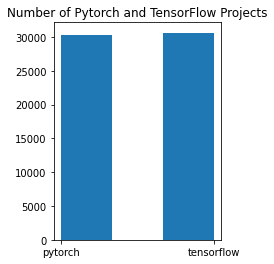

In [213]:
# visualise number of Pytorch and TensorFlow projects
plt.figure(figsize=(3,4))
plt.hist(df1["Project_type"],bins=3)
plt.title("Number of Pytorch and TensorFlow Projects") 

Text(0.5, 1.0, 'Number of projects over time')

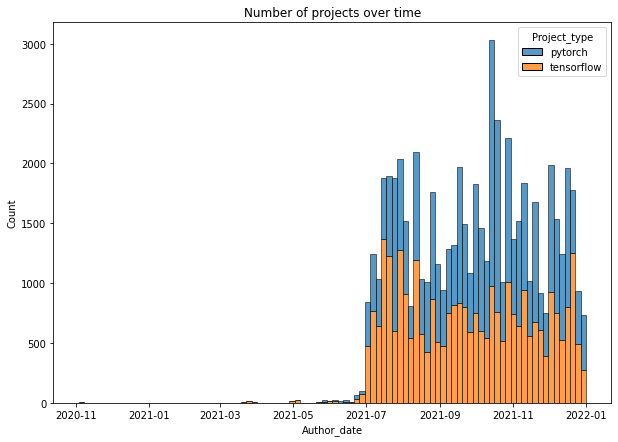

In [214]:
# visualise number of projects over time
plt.figure(figsize=(10,7))
sns.histplot(x='Author_date', hue='Project_type',multiple='stack', data=df1)
plt.title("Number of projects over time") 

Text(0.5, 1.0, 'Number of projects committed over time')

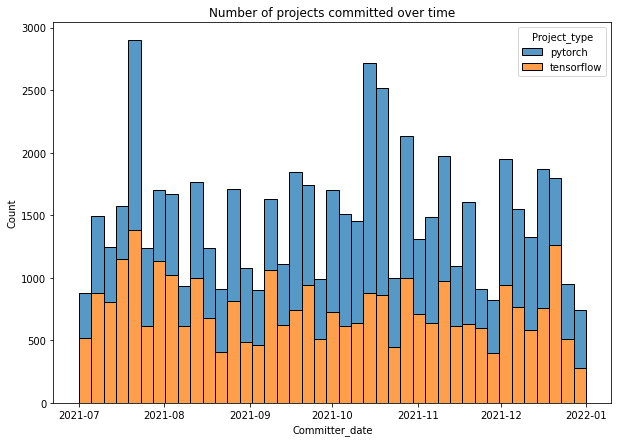

In [217]:
df2 = df_gitData.select(['Commit.Committer.Committer_date', "Project_name.Project_type"
                  ]) \
         .toPandas()

# visualise number of projects over time
plt.figure(figsize=(10,7))
sns.histplot(x='Committer_date', hue='Project_type',multiple='stack', data=df2)
plt.title("Number of projects committed over time") 

In [355]:
# filter out author names 
df_gitData.createOrReplaceTempView('author_names')

# filter out pytorch projects and their author timezone that 
author_names = spark_mongo_gitData.sql(
    """
    SELECT Commit.Msg.Author.Author_name, Project_name.Project_type
    FROM author_names
    """
).toPandas()

author_names_all = author_names.copy()

#drop duplicates of author_names
author_names_all.drop_duplicates(inplace=True, ignore_index=True)
author_names_all

,Author_name,Project_type
0,Jane Xu,pytorch
1,Vitaly Fedyunin,pytorch
2,Jeffrey Wan,pytorch
3,Peter Bell,pytorch
4,Brian Hirsh,pytorch
...,...,...
1106,Jianwei Xie,tensorflow
1107,Alan Kelly,tensorflow
1108,Martin Wicke,tensorflow
1109,Uday Bondhugula,tensorflow


In [260]:
author_names_all['Author_name'].nunique()

1102

In [258]:
author_names = author_names_all.groupby(['Author_name'])['Author_name'].size().sort_values(ascending=False)
author_names_df = pd.DataFrame(author_names)
author_names_df.head(10)

# there are 9 out of 1102 people who are in both types of projects: tensorflow and pytorch 

,Author_name
Author_name,
Sean Silva,2
Sergii Khomenko,2
rui,2
frgfm,2
Tao Xu,2
Jim,2
Alexander Grund,2
=,2
Michael Melesse,2


In [ ]:
# venn diagram


In [365]:
# calculate top author
author_names.groupby(['Author_name'], as_index = False)['Author_name'].size().sort_values(ascending = False, by = 'size')[10]

,Author_name,size
2,A. Unique TensorFlower,7339
594,Nikita Shulga,1918
674,Richard Barnes,1520
630,Peter Bell,1353
197,David Majnemer,1301
...,...,...
788,Steven Jin,1
950,aeioaeu,1
334,Igor Sugak,1
953,alesapin,1


In [367]:
# calculate top committer
df2.groupby(['Committer_name'], as_index = False)['Committer_name'].size().sort_values(ascending = False, by = 'size')

,Committer_name,size
114,TensorFlower Gardener,28042
34,Facebook GitHub Bot,24869
39,GitHub,4587
152,jagadeesh,318
99,Samuel Marks,205
...,...,...
75,Mihai Maruseac,1
68,Mark Harfouche,1
66,MaoXianxin,1
59,Kulin Seth,1


In [262]:
# Create a temporary table 
df_gitData.createOrReplaceTempView('tensorflow')

# filter out tensorflow projects and their author timezone 
tensorflow_timezone = spark_mongo_gitData.sql(
    """
    SELECT Commit.Msg.Author.Author_timezone
    FROM tensorflow
    WHERE Project_name.Project_type = "tensorflow"
    ORDER BY Commit.Msg.Author.Author_timezone DESC
    """
).toPandas()

tensorflow_timezone

,Author_timezone
0,28800
1,28800
2,28800
3,28800
4,28800
...,...
30636,-39600
30637,-39600
30638,-39600
30639,-39600


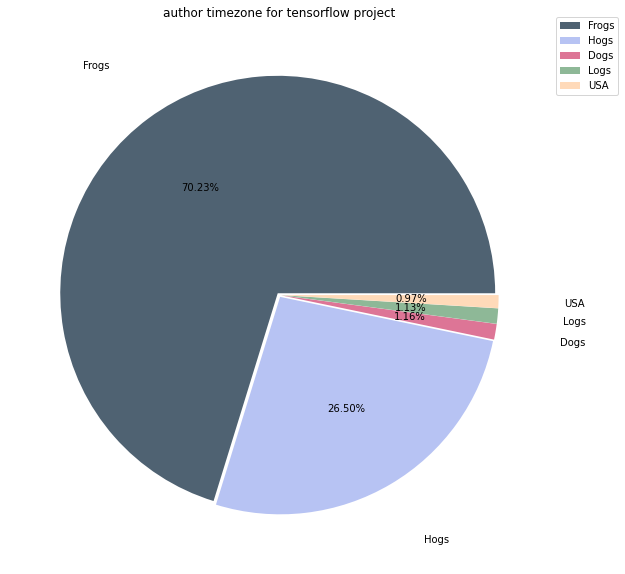

In [263]:
#plot the pie chart for tensorflow author_timezone project
import matplotlib.pyplot as plt
timezone_grouped = tensorflow_timezone.groupby(['Author_timezone'])['Author_timezone'].size().sort_values(ascending=False) 
df_tensor_timezone = pd.DataFrame(timezone_grouped)
#pick the top 5 timezones
df_tensor_timezone_filtered = df_tensor_timezone['Author_timezone'].nlargest(n=5)
#visulise the data
explode = (0.01, 0.01, 0.01, 0.01, 0.01)
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs', 'USA'
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', 'peachpuff']
ax = df_tensor_timezone_filtered.plot(y='Author_timezone',
                             kind = 'pie',
                            figsize=(10, 10),
                            title = 'Top 5 author timezone for tensorflow project',
                            autopct = "%.2f%%",
                            ylabel = '',
                            labeldistance = 1.3,
                            explode = explode,
                            labels = labels,
                            colors = colors)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [370]:
# Create a temporary table 
df_gitData.createOrReplaceTempView('pytorch')

# filter out pytorch projects and their author timezone that 
pytorch_timezone = spark_mongo_gitData.sql(
    """
    SELECT Commit.Msg.Author.Author_timezone
    FROM pytorch
    WHERE Project_name.Project_type = "pytorch"
    ORDER BY Commit.Msg.Author.Author_timezone DESC
    """
).toPandas()

pytorch_timezone

,Author_timezone
0,28800
1,28800
2,28800
3,28800
4,28800
...,...
30350,-32400
30351,-32400
30352,-32400
30353,-32400


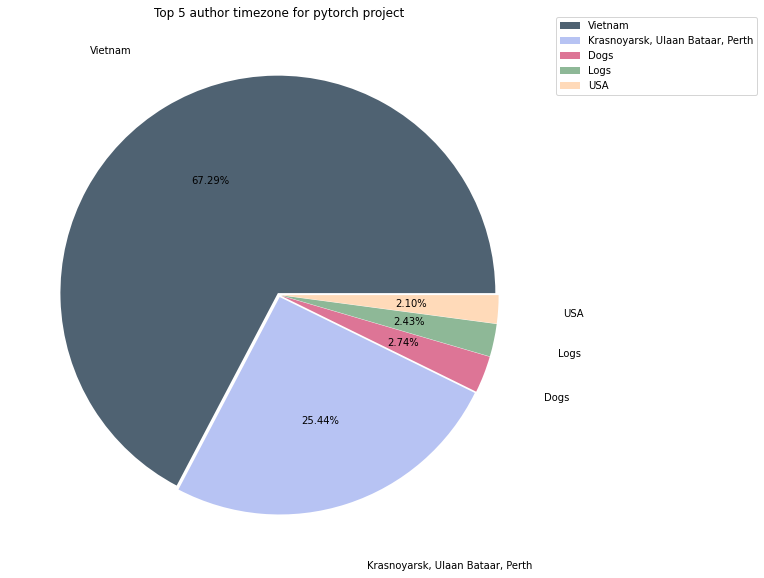

In [374]:
#plot the pie chart for pytorch author_timezone project
import matplotlib.pyplot as plt
pytorch_grouped = pytorch_timezone.groupby(['Author_timezone'])['Author_timezone'].size().sort_values(ascending=False) 
df_pytorch_timezone = pd.DataFrame(pytorch_grouped)

#pick the top 5 timezones
df_pytorch_timezone_filtered = df_pytorch_timezone['Author_timezone'].nlargest(n=5)

#visulise the data
explode = (0.01, 0.01, 0.01, 0.01, 0.01)
labels = 'Vietnam', 'Krasnoyarsk, Ulaan Bataar, Perth', 'Dogs', 'Logs', 'USA'
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', 'peachpuff']
ax = df_pytorch_timezone_filtered.plot(y='Author_timezone',
                             kind = 'pie',
                            figsize=(10, 10),
                            title = 'Top 5 author timezone for pytorch project',
                            autopct = "%.2f%%",
                            ylabel = '',
                            labeldistance = 1.3,
                            explode = explode,
                            labels = labels,
                            colors = colors)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [ ]:
# let's inspect data on complexity over 
df1 = df_gitData.select(['Commit.Msg.Author.Author_date', "Project_name.Project_type"
                  ]) \
         .toPandas() 

In [320]:
# Complexity of the projects
df_gitData.createOrReplaceTempView('complexity')

# Run a simple SQL command
df5 = spark_mongo_gitData.sql(
    """
    SELECT Complexity,Commit.Committer.Committer_date,Project_name.Project_type
    FROM gitTable_1
    ORDER BY Project_name.Project_type DESC
    """).toPandas()

In [323]:
# drop NA in the df
df5 = df5[df5['Complexity'].notna()]

#remove the seconds in the date
df5['Committer_date'] = df5['Committer_date'].apply(lambda t: t.strftime('%Y-%m-%d'))

df5

,Complexity,Committer_date,Project_type
0,244.0,2021-10-15,tensorflow
1,19.0,2021-10-15,tensorflow
2,4800.0,2021-10-02,tensorflow
3,237.0,2021-08-02,tensorflow
6,12.0,2021-12-20,tensorflow
...,...,...,...
60991,0.0,2021-09-21,pytorch
60992,27.0,2021-09-21,pytorch
60993,23.0,2021-09-21,pytorch
60994,29.0,2021-09-21,pytorch


In [324]:
#separate the project into pytorch and tensorflow
df_torch = df5.loc[df5['Project_type'] == 'pytorch']
df_tensor = df5.loc[df5['Project_type'] == 'tensorflow']

# Average complexity of the projects per day
df_torch_grouped =df_torch.groupby(['Committer_date'],as_index=False).mean()
df_tensor_grouped =df_tensor.groupby(['Committer_date'],as_index=False).mean()

Text(0.5, 1.0, 'Average Complexity over time')

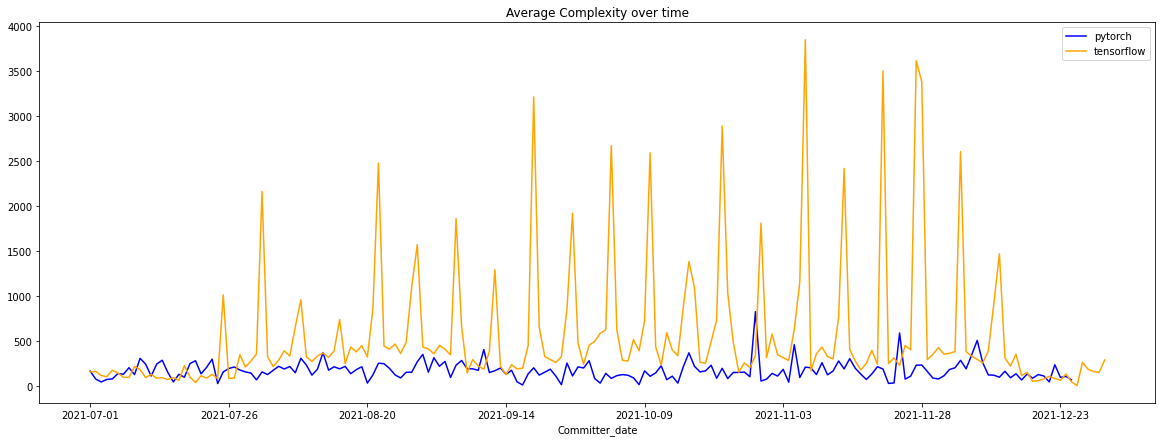

In [375]:
# visualise complexity over time
ax = df_torch_grouped.plot(x = 'Committer_date', y ='Complexity',figsize=(20,7),color="blue",label="pytorch")
df_tensor_grouped.plot(x = 'Committer_date', y ='Complexity',figsize=(20,7),color="orange",label="tensorflow",ax=ax)
plt.title("Average Complexity over time")

In [ ]:
# does the author approve the committer - compare tensorflow vs pytorch
# user that start making changes to the commit - committer 


In [377]:
# assume committer_date is the end of the project
# Committed_date, Author_date 
df_gitData.createOrReplaceTempView('duration')

# Run a simple SQL command
df6 = spark_mongo_gitData.sql(
    """
    SELECT Commit.Committer.Committer_date,Commit.Msg.Author.Author_date,Project_name.Project_type
    FROM duration
    ORDER BY Project_name.Project_type DESC
    """).toPandas()
# visualise project duration 
df6

,Committer_date,Author_date,Project_type
0,2021-10-15 04:17:25,2021-10-15 04:17:25,tensorflow
1,2021-10-15 04:17:59,2021-10-15 04:17:59,tensorflow
2,2021-10-02 05:51:15,2021-10-02 05:46:49,tensorflow
3,2021-08-02 04:01:57,2021-08-02 04:01:57,tensorflow
4,2021-12-30 11:42:48,2021-12-30 11:36:34,tensorflow
...,...,...,...
60991,2021-09-21 02:31:11,2021-09-21 01:34:28,pytorch
60992,2021-09-21 02:31:11,2021-09-21 01:34:28,pytorch
60993,2021-09-21 02:31:11,2021-09-21 01:34:28,pytorch
60994,2021-09-21 02:31:11,2021-09-21 01:34:28,pytorch


In [385]:
# convert to datetime
df6['Committer_date'] = pd.to_datetime(df6['Committer_date'])
# strip seconds 
df6['Committer_date'] = df6['Committer_date'].apply(lambda t: t.strftime('%Y-%m-%d'))
df6['Author_date'] = df6['Author_date'].apply(lambda t: t.strftime('%Y-%m-%d'))

In [393]:
df6['Committer_date'] = pd.to_datetime(df6['Committer_date'])
df6['Author_date'] = pd.to_datetime(df6['Author_date'])
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60996 entries, 0 to 60995
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Committer_date  60996 non-null  datetime64[ns]
 1   Author_date     60996 non-null  datetime64[ns]
 2   Project_type    60996 non-null  object        
dtypes: datetime64[ns](2), object(1)
memory usage: 1.4+ MB


In [ ]:
df6['duration'] = df6['Committer_date'] - df6['Author_date']
df6["duration"].describe()

In [401]:
df_torch_new = df6.loc[df6['Project_type'] == 'pytorch']
df_tensor_new = df6.loc[df6['Project_type'] == 'tensorflow']


In [403]:
df_tensor_new['duration'].describe()

count                         30641
mean      1 days 02:12:54.256714859
std      10 days 12:24:32.775684061
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 0 days 00:00:00
75%                 0 days 00:00:00
max               300 days 00:00:00
Name: duration, dtype: object

In [404]:
df_torch_new['duration'].describe()

count                        30355
mean     0 days 07:46:22.157799374
std      4 days 13:34:10.673669740
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max               97 days 00:00:00
Name: duration, dtype: object